###   Unsupervised learning using Autoencoders, PCA and Clustering on Fashion-MNIST

Imports & Reproducibility

In [1]:
#imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import count

import medmnist
from medmnist import INFO, Evaluator

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

#Setting Random Seed
np.random.seed(12345) 
torch.manual_seed(12345)

### Unsupervised learning on Fashion-MNIST

#### Importing the data

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data.
Display at least ten images for each class for each train test and validation set.

In [2]:
#Function to print images
def print_image(dataset,label):
    i=0
    for img,lbl in dataset:
        if lbl == label:
            display(img)
            i = i+1
        if i == 10:
            break

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])           

#function to transform 3D array to a 2D array
def transform_3d_2d(dataset):
    n, n1, n2 = dataset.shape
    dataset_2d = dataset.reshape((n,n1*n2))
    return dataset_2d

#load the test set from the Fashion MNIST dataset
fashionM_test = datasets.FashionMNIST(root="./data", download=True, transform=data_transform, train= False)

#subset the test dataset into just two labels
required = (fashionM_test.targets==0)|(fashionM_test.targets==9) #Classes chosen were 0 and 9 Shirts and Ankle Boots
fashionM_test.data = fashionM_test.data[required]
fashionM_test.targets = fashionM_test.targets[required]

fashion_test = list(fashionM_test)

### Dimensionality reduction and clustering

#### PCA
- Apply PCA to all images of classes 0 and 9. Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first)

In [3]:
#Convert the Dataset into a numpy array
X = np.array(fashion_test[:][0][0].numpy()).reshape(1, 28*28)
y = np.array(fashion_test[:][0][1])
for i in range(1, len(fashion_test[:])):
    X = np.append(X,np.array(fashion_test[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
    y = np.append(y,np.array(fashion_test[:][i][1]))

#Standardise the data
X = StandardScaler().fit_transform(X)

EigenValue 1: 219.45925903320312
EigenValue 2: 115.883056640625
EigenValue 3: 55.88566589355469
EigenValue 4: 28.658050537109375
EigenValue 5: 22.687814712524414


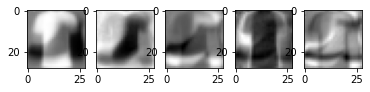

In [4]:
#initialize and fit PCA over the test data
pca = PCA(n_components = 0.99)
pca.fit(X)

#calculate the covariance matrix
cov_matrix = np.dot(X.T, X) / len(X)

#loop over the top 5 eigenvectors and display them as images alongside their eigenvalues
for i,eigenvector in enumerate(pca.components_[0:5]):
    plt.subplot(1, 5, i+1)
    print(f'EigenValue {i+1}: {np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))}')
    plt.imshow(eigenvector.reshape(28,28),cmap='gray')

#### Use the top 30 PCs to reconstruct 10 images, with 5 from each class . Show these 10 pairs of reconstructed and original images.

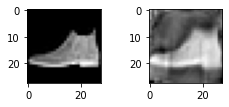

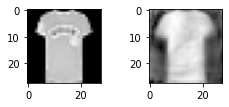

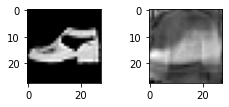

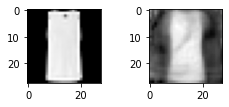

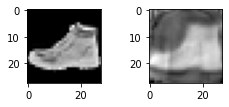

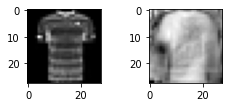

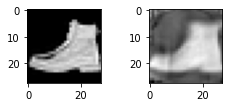

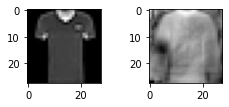

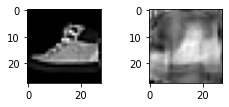

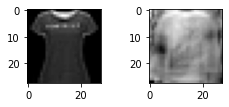

<Figure size 288x1152 with 0 Axes>

In [5]:
#Storing the top 30 PCAs
pca.components_ = pca.components_[:30]

total_0 = 0 #Handler variable to check total number of class 1 images printed
total_9 = 0 #Handler variable to check total number of class 1 images printed
i=0
#Reconstruct 5 Images from each class
for img,label in fashion_test:
    plt.figure(figsize = (4,16))
    if label == 0 and total_0 < 5:
        img_inverse = pca.inverse_transform(pca.transform(np.array(img).reshape(1,28*28))) #Reconstructing images
        plt.subplot(10, 2, i+1)
        plt.imshow(img.reshape(28,28),cmap='gray')
        i =i+1
        plt.subplot(10, 2, i+1)
        plt.imshow(img_inverse.reshape(28,28),cmap='gray')
        i =i+1
        total_0 = total_0+1 
    elif label == 9 and total_9 < 5:
        img_inverse = pca.inverse_transform(pca.transform(np.array(img).reshape(1,28*28))) #Reconstructing images
        plt.subplot(10, 2, i+1)
        plt.imshow(img.reshape(28,28),cmap='gray')
        i =i+1
        plt.subplot(10, 2, i+1)
        plt.imshow(img_inverse.reshape(28,28),cmap='gray')
        i =i+1
        total_9 = total_9+1 
    elif total_0 == 5 and total_9 == 5:
        break

#### Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. using the top two PCs)

In [6]:
#Storing the top two PCA Components
PCA_1 = pca.components_[0]
PCA_2 = pca.components_[1]

In [7]:
data_1_x = []
data_0_x = []
data_1_y = []
data_0_y = []
i = 0
data_pca = np.zeros([len(fashion_test), 2])
labels_pca = np.zeros([len(fashion_test)])
#calculate the PCA1 and PCA2 transforms of all datapoints and store them as an array alongside their labels
for img,label in fashion_test:
    pca.components_ = PCA_1
    x_plot = float(pca.transform(np.array(img).reshape(1,28*28)))
    pca.components_ = PCA_2
    y_plot = float(pca.transform(np.array(img).reshape(1,28*28)))
    if label==0:
        data_1_x.append(x_plot)
        data_1_y.append(y_plot)
    elif label==9:
        data_0_x.append(x_plot)
        data_0_y.append(y_plot)
    data_pca[i] = np.array([x_plot,y_plot])
    labels_pca[i] = int(label)
    i = i+1

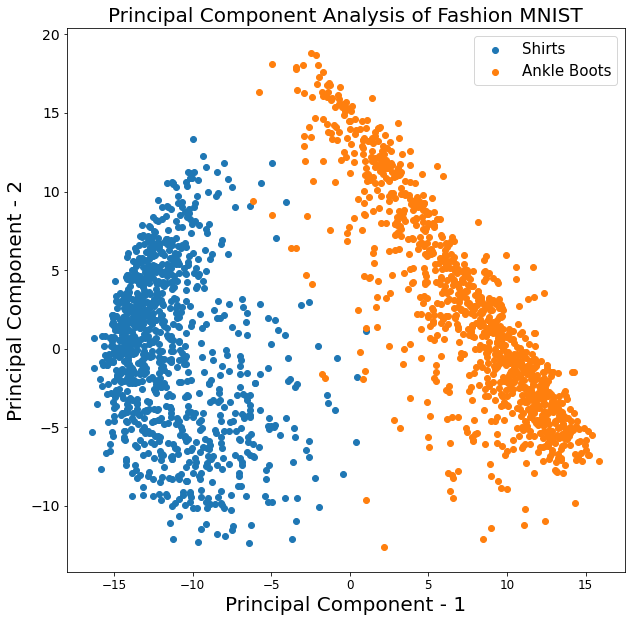

In [8]:
#plot the PCA1 and PCA2 Transforms of the dataset
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Fashion MNIST",fontsize=20)

plt.scatter(data_0_x,data_0_y)
plt.scatter(data_1_x,data_1_y)

plt.legend(['Shirts','Ankle Boots'],prop={'size': 15})

#### Spectral Clustering
 - Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers in 2D.

In [9]:
#create a spectral clustering object with n_clusters=2
sc = SpectralClustering(n_clusters=2)
#fit the object with the PCA 1 and PCA 2 co-ordinate data array from previous question
sc.fit(data_pca)
#extract the generated cluster labels
labels = sc.labels_

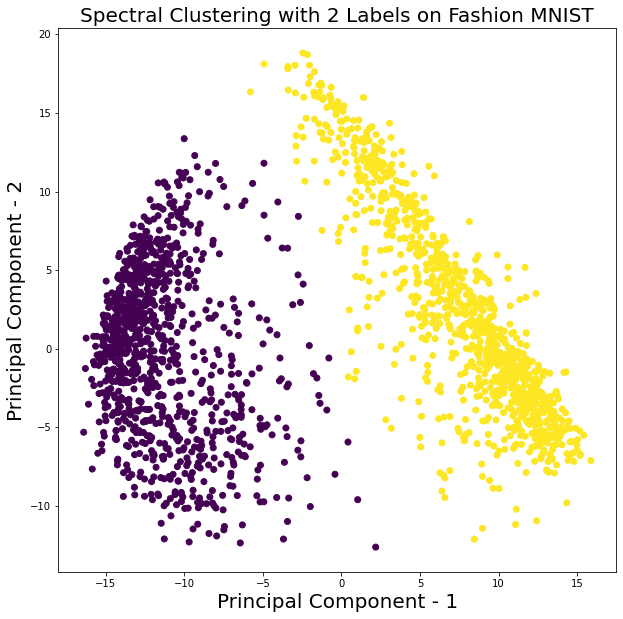

In [10]:
#plot the datapoints along with the generate labels
plt.figure(figsize = (10,10))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Spectral Clustering with 2 Labels on Fashion MNIST",fontsize=20)
plt.scatter(data_pca[:,0], data_pca[:,1], c=labels)

### Unsupervised Learning - Autoencoders

Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers, activation function used is  rectified linear activation function or ReLU, Optimizer used is Stochastic gradient descent Optimizer.

In [11]:
#Create an AutoEncoder Class --------- 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 5)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
#initialize Parameters
batch_size=128
learning_rate=1e-1
max_epochs = 20

In [13]:
#Initialize autoencoder object , loss function and optimizer
myAE=Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(myAE.parameters(),lr=learning_rate, weight_decay = 0.0042)
f_test_loader = data.DataLoader(dataset=(fashionM_test), batch_size=batch_size, shuffle=False)
results = np.zeros([20,2])
results2 = np.zeros([1280,2])

In [14]:
#Train the autoencoder on test data
i = 0
for epoch in range(max_epochs):
    myAE.train()
    for inputs, targets in (f_test_loader):
        optimizer.zero_grad() #set gradients to zero
        outputs = myAE(inputs) #calculate outputsxxxxxxxxxxxxxxxxxxxxxxxzxx
        loss = criterion(outputs, inputs) #Calculate the loss between actual data and encoded/decoded data
        results2[i] = ([i,float(loss)])
        loss.backward() #compute Gradient
        optimizer.step() #update Parameters
        i=i+1
    results[epoch] = ([epoch,float(loss)])

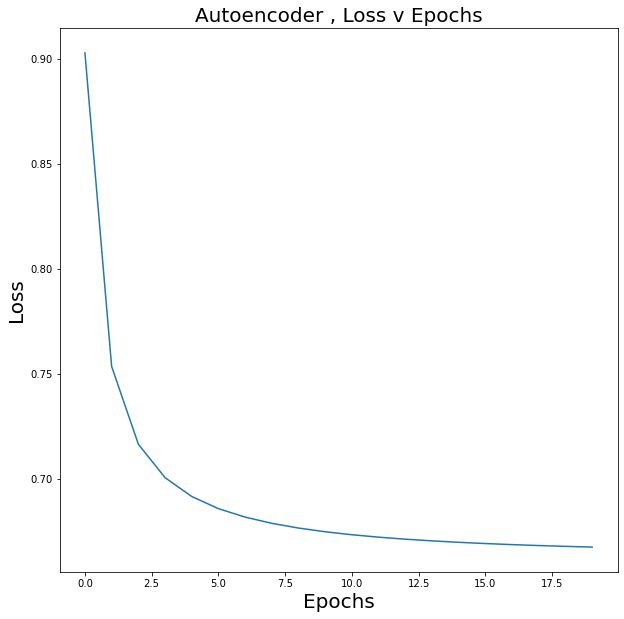

In [15]:
#plot the loss at every epoch
plt.figure(figsize = (10,10))
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title("Autoencoder , Loss v Epochs",fontsize=20)
plt.plot(results[:,0],results[:,1])

observations.

1. Experimenting with different learning rates using the optimizer, at very low learning rates the the graph of loss v epochs becomes a y=-x+C straightline; eventually converging given enough epochs, while at high learning rates the graph drops sleeply for the first couple of epochs and strats converging quickly over the remainder.
2. Even without spectral clustering there is a visible distinction (after Plotting) between datapoints of the different classes over their top two PCA plots 
3. If Sneakers and bags were used as classes in the dataset then some of the recontructed images of the top 30 PCA transformations were horizontally inverted and spetral clustering classified 50% of the sneakres datapoint to be bags . Hence I ended up going with shirts and ankle boots